In [2]:
!pip install "numpy<2.0"
!pip install --upgrade mediapipe
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
#2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    if image is None:
        print("Empty image received in mediapipe_detection")
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion
    image.flags.writeable = False                 # Image is no longer writable
    results = model.process(image)                # Make prediction
    image.flags.writeable = True                  # image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color conversion
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


In [7]:
def draw_styled_landmarks(image, results):
    if results:
        # Draw Face Landmarks
        if results.face_landmarks:
            mp_drawing.draw_landmarks(
                image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
            )
        # Draw Pose Landmarks
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
            )
        # Draw Left Hand Landmarks
        if results.left_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
            )
        # Draw Right Hand Landmarks
        if results.right_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
            )


In [8]:
cv2.startWindowThread()

#if no popup, try 1 or 2
cap = cv2.VideoCapture(1)

# Access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
    
        #Read Feed
        ret, frame = cap.read()
    
        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw Landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
    
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

I0000 00:00:1728571850.646737 10650354 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1728571850.777790 10651279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728571850.796554 10651275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728571850.800080 10651280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728571850.800165 10651275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728571850.800732 10651278 inference_feedback_manager.cc:114] Feedback manager requ

In [9]:
draw_landmarks(frame, results)

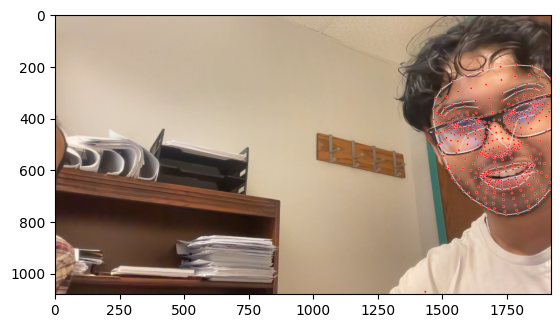

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [11]:
# 3. Extract Keypoint Values

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [13]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [14]:
def extract_keypoints(results):
    # Initialize empty arrays for landmarks with zeros
    pose = np.zeros(132)     # 33 landmarks * 4 (x, y, z, visibility)
    face = np.zeros(1404)    # 468 landmarks * 3 (x, y, z)
    lh = np.zeros(63)        # 21 landmarks * 3 (x, y, z)
    rh = np.zeros(63)        # 21 landmarks * 3 (x, y, z)

    # Extract pose landmarks if detected
    if results.pose_landmarks:
        pose_landmarks = results.pose_landmarks.landmark
        pose = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in pose_landmarks]).flatten()

    # Extract face landmarks if detected
    if results.face_landmarks:
        face_landmarks = results.face_landmarks.landmark
        face = np.array([[lm.x, lm.y, lm.z] for lm in face_landmarks]).flatten()

    # Extract left hand landmarks if detected
    if results.left_hand_landmarks:
        lh_landmarks = results.left_hand_landmarks.landmark
        lh = np.array([[lm.x, lm.y, lm.z] for lm in lh_landmarks]).flatten()

    # Extract right hand landmarks if detected
    if results.right_hand_landmarks:
        rh_landmarks = results.right_hand_landmarks.landmark
        rh = np.array([[lm.x, lm.y, lm.z] for lm in rh_landmarks]).flatten()

    # Concatenate all arrays
    keypoints = np.concatenate([pose, face, lh, rh])
    return keypoints


In [15]:
extract_keypoints(results)

array([ 0.91295117,  0.48278135, -1.08053851, ...,  0.        ,
        0.        ,  0.        ])

In [16]:
# 4. Setup Folders for Collection
# DATA COLLECTION
# Maybe try putting this and 5 in a seperate file just for collecting data

In [21]:
#Path for exported data, np arrays
#Try to go to this path and find the files, then add more
DATA_PATH = os.path.join("MP_Data")
#Actions to try and detect
####### ADD TO THIS EXTRA SIGNS YOU WANT TO ADD
####### THEN ONCE DONE TRAINING ADD ALL DATA TO GITHUB
####### IF TRAINING DATA IS BAD DELETE MP_DATA FOLDER AND RE-RUN THIS BLOCK
actions = np.array(["hello", "thanks", "iloveyou"])
# 30 videos worth of data
no_sequences = 30
# videos are going to be 30 frames in length
sequence_length = 30

In [150]:
# hello
## 
# thanks

# I love you

In [151]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [99]:
# 5. Collect Keypoint Values for Training and Testing

In [100]:
cv2.startWindowThread()

#if no popup, try 1 or 2
cap = cv2.VideoCapture(1)

# Access mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
    
                #Read Feed
                ret, frame = cap.read()
            
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
        
                # Draw Landmarks
                draw_styled_landmarks(image, results)

                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, "STARTING COLLECTION", (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, "Collecting frames for {} Video Number {}".format(action, sequence), (15, 12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 225), 1, cv2.LINE_AA)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image, "Collecting frames for {} Video Number {}".format(action, sequence), (15, 12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0, 225), 1, cv2.LINE_AA)

                # Extract keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
    
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

I0000 00:00:1728001927.404707 7946966 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1 Pro
W0000 00:00:1728001927.508418 8017098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728001927.525067 8017098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728001927.528353 8017103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728001927.528609 8017101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728001927.529158 8017098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

In [22]:
# 6. Preprocess Data and Create Labels and Features

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
label_map = {label:num for num, label in enumerate(actions)}

In [25]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [26]:
sequences, labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [27]:
y = to_categorical(labels).astype(int)

In [28]:
def trim_frame(frame, expected_length=1662):
    if frame.shape[0] > expected_length:
        # Trim the frame to the expected length
        return frame[:expected_length]
    elif frame.shape[0] < expected_length:
        # Pad the frame with zeros if it's shorter
        padding = np.zeros(expected_length - frame.shape[0])
        return np.concatenate([frame, padding])
    else:
        return frame

for i, seq in enumerate(sequences):
    fixed_seq = []
    for j, frame in enumerate(seq):
        fixed_frame = trim_frame(np.array(frame))
        fixed_seq.append(fixed_frame)
    sequences[i] = fixed_seq

In [29]:
for i, seq in enumerate(sequences):
    for j, frame in enumerate(seq):
        if frame.shape != (1662,):
            print(f"Sequence {i}, Frame {j} has incorrect length: {frame.shape}")

In [30]:
X = np.array(sequences)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [32]:
X_test.shape

(5, 30, 1662)

In [33]:
# 7 Build and Train LSTM Neural Network
#try training with one set of data then try training in the same session
#with a different set of data, and see if camera will recognize
#both

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [35]:
log_dir = os.path.join("Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [106]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define your model architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [107]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [112]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model with validation data and callbacks
model.fit(
    X_train, y_train,
    validation_split=0.2,  # Or use validation_data=(X_val, y_val) if you have validation data
    epochs=500,
    callbacks=[tb_callback, early_stopping, checkpoint]
)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_accuracy: 0.9125 - loss: 0.2583 - val_categorical_accuracy: 0.9412 - val_loss: 0.2218
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.8982 - loss: 0.2141 - val_categorical_accuracy: 0.9412 - val_loss: 0.2147
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.9281 - loss: 0.2112 - val_categorical_accuracy: 0.9412 - val_loss: 0.2022
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.8640 - loss: 0.2547 - val_categorical_accuracy: 0.9412 - val_loss: 0.2047
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.8865 - loss: 0.2339 - val_categorical_accuracy: 0.7647 - val_loss: 0.3763
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - categorical_accuracy: 0.8713 - loss: 0.2696 - val_categorical_accuracy: 0.9412 - val_loss: 0.1972
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - categorical_accuracy: 0.8899 - loss: 0.2255 - va

In [113]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

In [114]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


In [117]:
actions[np.argmax(res[1])]

'thanks'

In [118]:
actions[np.argmax(y_test[1])]

'thanks'

In [79]:
# 9. Save Weights

In [95]:
#model.save('action.keras')

In [72]:
#del model
# After doing this, go back up to model definition and run it, and compile block again
# Then, skip this block and load the next block
# OPTIONAL, SKIP

In [120]:
model.load_weights('best_model.keras')

In [121]:
# 10. Evaluate using Confusion Matrix and Accuracy

In [122]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [123]:
yhat = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


In [124]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [126]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[53,  3],
        [ 4, 25]],

       [[57,  0],
        [ 0, 28]],

       [[53,  4],
        [ 3, 25]]])

In [127]:
accuracy_score(ytrue, yhat)

0.9176470588235294

In [130]:
# 11. Test in Real Time

In [131]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [132]:
plt.figure(figsize = (18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [133]:
# 1. Detection Variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

cap = cv2.VideoCapture(1)

with mp_holistic.Holistic(
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5
) as holistic:
    while cap.isOpened():
        # Read Feed
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw Landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(f"Prediction probabilities: {res}")
            print(f"Predicted action: {actions[np.argmax(res)]}")
            predictions.append(np.argmax(res))

            # 3. Visualization logic
            if len(predictions) >= 10:
                recent_predictions = predictions[-10:]
                unique_predictions = np.unique(recent_predictions)
                if len(unique_predictions) == 1 and unique_predictions[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                    if len(sentence) > 5:
                        sentence = sentence[-5:]

            # Visualization Probabilities
            image = prob_viz(res, actions, image, colors)

        # Display the output
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(
            image, ' '.join(sentence), (3, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, 
            (255, 255, 255), 2, cv2.LINE_AA
        )

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)


I0000 00:00:1728589384.609823 10650354 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1 Pro
W0000 00:00:1728589384.716803 10760479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728589384.740405 10760479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728589384.743391 10760481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728589384.744067 10760479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728589384.748011 10760483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [5.4826452e-15 0.0000000e+00 1.0000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction probabilities: [2.4007941e-18 0.0000000e+00 1.0000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [5.633522e-19 0.000000e+00 1.000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [4.8353285e-18 0.0000000e+00 1.0000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction probabilities: [1.0408736e-18 0.0000000e+00 1.0000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [4.913889e-19 0.000000e+00 1.000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [4.5404304e-18 0.0000000e+00 1.0000000e+00]
Predicted action: iloveyou
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction probabilitie

In [146]:
np.expand_dims(X_test[0], axis=0).shape

(1, 30, 1662)

In [147]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[4.4357101e-05, 9.9995565e-01, 1.5758536e-08]], dtype=float32)

In [148]:
if len(sequence) == 30:
    res = model.predict(np.expand_dims(sequence, axis=0))[0]
    print(f"Prediction probabilities: {res}")
    print(f"Predicted action: {actions[np.argmax(res)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction probabilities: [0. 0. 1.]
Predicted action: iloveyou
